In [1]:
import pandas as pd
import numpy as np 

from pathlib import Path

## load data + clean

In [10]:
path = Path("account-sharing-export/auth_events.csv")

rows = []
with path.open("r", encoding="utf-8", errors="replace") as f:
    header = f.readline().rstrip("\n").split(",")
    assert header == ["user_id","event_type","event_timestamp","ip_address","user_agent"]

    for line in f:
        parts = line.rstrip("\n")
        if not parts:
            continue

        # split on first 4 commas only
        user_id, event_type, event_timestamp, ip_address, user_agent = parts.split(",", 4)
        rows.append((user_id, event_type, event_timestamp, ip_address, user_agent))

auth_events = pd.DataFrame(rows, columns=header)

auth_events.head()

,user_id,event_type,event_timestamp,ip_address,user_agent
0,a6d983a8-133f-4287-a47d-aabb167bdd49,forgotPassword,2025-12-09 04:31:49,130.65.254.15|10.3.3.254,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...
1,e79ea4fd-84a0-49e9-a923-74100e822801,forgotPassword,2025-07-18 16:13:49,171.158.162.34|10.3.2.180,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2,8b7826d1-9011-4deb-8351-b324a0531589,forgotPassword,2025-08-01 14:16:01,47.17.253.179|10.3.2.77,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,7f620264-b87d-4c81-acf6-ff1f1375e951,forgotPassword,2025-10-12 22:27:46,70.113.153.4|10.3.3.22,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,942159f6-673d-4d8b-9ec9-5ca4276ae4f7,forgotPassword,2025-09-16 03:19:42,68.2.160.173|10.3.3.80,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [23]:
# convert event_timestamp to date time

auth_events["event_timestamp"] = pd.to_datetime(
    auth_events["event_timestamp"],
    errors="coerce",
    utc= True # ask client about this
)

#
auth_events["date"] = auth_events["event_timestamp"].dt.date
auth_events["hour"] = auth_events["event_timestamp"].dt.hour
auth_events["dow"] = auth_events["event_timestamp"].dt.day_name()


In [24]:
print(auth_events.shape)
print(auth_events.dtypes)
print(auth_events.isna().sum())

(107943, 8)
user_id                            str
event_type                         str
event_timestamp    datetime64[us, UTC]
ip_address                         str
user_agent                         str
date                            object
hour                             int32
dow                                str
dtype: object
user_id            0
event_type         0
event_timestamp    0
ip_address         0
user_agent         0
date               0
hour               0
dow                0
dtype: int64


In [25]:
auth_events.head()

,user_id,event_type,event_timestamp,ip_address,user_agent,date,hour,dow
0,a6d983a8-133f-4287-a47d-aabb167bdd49,forgotPassword,2025-12-09 04:31:49+00:00,130.65.254.15|10.3.3.254,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2025-12-09,4,Tuesday
1,e79ea4fd-84a0-49e9-a923-74100e822801,forgotPassword,2025-07-18 16:13:49+00:00,171.158.162.34|10.3.2.180,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2025-07-18,16,Friday
2,8b7826d1-9011-4deb-8351-b324a0531589,forgotPassword,2025-08-01 14:16:01+00:00,47.17.253.179|10.3.2.77,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2025-08-01,14,Friday
3,7f620264-b87d-4c81-acf6-ff1f1375e951,forgotPassword,2025-10-12 22:27:46+00:00,70.113.153.4|10.3.3.22,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2025-10-12,22,Sunday
4,942159f6-673d-4d8b-9ec9-5ca4276ae4f7,forgotPassword,2025-09-16 03:19:42+00:00,68.2.160.173|10.3.3.80,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2025-09-16,3,Tuesday


# Helper functions

In [52]:
def filter_month(df, year, month, ts_col="event_timestamp"):
    # Create timezone-aware boundaries in UTC
    start = pd.Timestamp(year=year, month=month, day=1, tz="UTC")
    end = start + pd.offsets.MonthEnd(1) + pd.Timedelta(hours=23, minutes=59, seconds=59)
    return df[df[ts_col].between(start, end)].copy()

# EDA

## event type

In [26]:
auth_events["event_type"].value_counts()

event_type
signIn            84631
signOut           14791
signInFailed       3796
forgotPassword     2504
resetPassword      2221
Name: count, dtype: int64

<Axes: title={'center': 'Daily auth events by type'}, xlabel='date'>

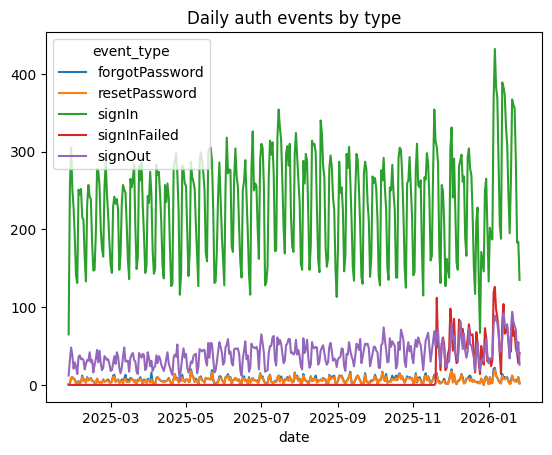

In [29]:
# daily authentication events by type

(
    auth_events
    .groupby(["date", "event_type"])
    .size()
    .unstack(fill_value=0)
    .plot(title="Daily auth events by type")
)

## investigate spike in signinfailed in november

In [53]:
november_events = filter_month(auth_events, 2025, 11)
november_events.head()

,user_id,event_type,event_timestamp,ip_address,user_agent,date,hour,dow
10,4b868c7a-f0fd-4e8f-a12a-aa23c29968e2,forgotPassword,2025-11-03 22:24:45+00:00,98.167.213.19|170.85.55.87|10.3.2.62,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2025-11-03,22,Monday
18,0a4cc535-ea0d-4612-8494-54debce0c853,forgotPassword,2025-11-04 01:00:14+00:00,152.8.78.44|10.3.3.59,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2025-11-04,1,Tuesday
25,81058572-8b48-4a4e-acee-a1d4635b4c49,forgotPassword,2025-11-06 21:15:05+00:00,108.147.92.126|10.3.3.215,Mozilla/5.0 (iPhone; CPU iPhone OS 18_5 like M...,2025-11-06,21,Thursday
37,5623c68f-4ff7-453c-9aaa-72a6a4c8d1c6,forgotPassword,2025-11-07 03:17:24+00:00,38.189.70.35|10.3.3.215,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2025-11-07,3,Friday
76,92920685-119d-46b0-b56c-cba705f3d710,forgotPassword,2025-11-20 04:41:02+00:00,174.163.137.27|10.3.3.254,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2025-11-20,4,Thursday


In [54]:
november_events["event_type"].value_counts()

event_type
signIn            6742
signOut           1396
signInFailed       522
forgotPassword     196
resetPassword      170
Name: count, dtype: int64

In [55]:
nov_summary = (
    november_events
    .groupby(["date", "event_type"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
nov_summary

event_type,forgotPassword,resetPassword,signIn,signInFailed,signOut
date,,,,,
2025-11-01,1,1,141,0,28
2025-11-02,4,3,145,0,47
2025-11-03,15,13,277,0,58
2025-11-04,3,4,310,0,49
2025-11-05,9,8,257,0,61
2025-11-06,10,7,254,0,55
2025-11-07,7,6,263,0,51
2025-11-08,1,1,172,0,36
2025-11-09,2,2,115,0,19


In [56]:
nov_failed = november_events[november_events["event_type"] == "signInFailed"]

print(nov_failed["user_id"].nunique())
print(nov_failed["ip_address"].nunique())


243
294


In [57]:
failed_daily = (
    nov_failed
    .groupby("date")
    .size()
    .sort_values(ascending=False)
)

failed_daily.head(10)


date
2025-11-20    112
2025-11-25     61
2025-11-24     53
2025-11-26     52
2025-11-21     48
2025-11-22     48
2025-11-30     46
2025-11-29     40
2025-11-28     22
2025-11-23     19
dtype: int64

In [58]:
day_failed = nov_failed[nov_failed["date"] == failed_daily.index[0]]
day_failed["event_timestamp"].dt.hour.value_counts().sort_index()

datetime.date(2025, 11, 20)

In [62]:
top_users = (
    nov_failed
    .groupby("user_id")
    .size()
    .sort_values(ascending=False)
)

top_users.head(20)

user_id
c68eee80-309e-4ce5-a62e-bbac5247f602    13
3c001e42-f92b-4ea5-b478-2d8eee5f272c    11
29bd0a8d-51d9-48f6-97b1-8f797f890324    11
7b76a080-2826-4723-985b-c7f3b099dac8    10
dd35cecf-d6fa-49fe-89aa-06a4284a8037     8
fb1dcf5f-1387-40fa-8438-c2270cced2a4     8
db34ce1d-7dba-4649-94de-59c74c57e83b     8
2d24307c-659e-4cf7-8d8e-45d3d55e44fc     8
cdb3c727-6f91-421c-88c7-2e4c5f0ea4cf     7
8e750c22-e55f-447e-8120-39bc201de062     7
03ba571b-fa44-4460-9bcc-d2b121bdfd89     7
d9259fe8-e4e7-44fd-b929-d17f66711dc0     6
a0589bbe-8eb6-4939-b5bd-fe6b394bf850     6
07e10e44-13a3-40d6-a3e9-b355704cfc82     6
30ae75ce-b26e-414b-8169-5a8ba7a71121     6
82ad9ff9-fd66-4828-8615-ffd6697fba43     6
b4699cd9-8575-43f7-955c-812a43a80012     5
db4b6623-58aa-4d09-a36a-29f9d248f58c     5
4ab5f2f4-63c7-4d11-8fa4-70a917f96155     5
2871354a-2877-4777-9795-2b7c6d7f9cc0     5
dtype: int64

In [63]:
nov_daily = (
    november_events
    .groupby(["date", "event_type"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

nov_daily[["signInFailed", "forgotPassword", "resetPassword"]].tail(20)


event_type,signInFailed,forgotPassword,resetPassword
date,,,
2025-11-11,0,15,12
2025-11-12,0,6,6
2025-11-13,0,11,11
2025-11-14,0,7,5
2025-11-15,0,2,2
2025-11-16,0,4,4
2025-11-17,0,8,7
2025-11-18,0,13,9
2025-11-19,2,13,13


## User lifecycle

In [64]:
user_lifecycle = (
    auth_events
    .groupby("user_id")
    .agg(
        first_event=("event_timestamp", "min"),
        last_event=("event_timestamp", "max"),
        n_events=("event_type", "count"),
    )
)

user_lifecycle["active_days"] = (
    user_lifecycle["last_event"] - user_lifecycle["first_event"]
).dt.days


In [65]:
user_lifecycle["active_days"].describe()


count    14939.000000
mean        75.730437
std         95.669173
min          0.000000
25%          0.000000
50%         31.000000
75%        127.000000
max        364.000000
Name: active_days, dtype: float64

## IP diversity per user

In [67]:
auth_events["ip_address"]

0                       130.65.254.15|10.3.3.254
1                      171.158.162.34|10.3.2.180
2                        47.17.253.179|10.3.2.77
3                         70.113.153.4|10.3.3.22
4                         68.2.160.173|10.3.3.80
                           ...                  
107938                   70.176.54.19|10.3.3.254
107939                   100.40.198.8|10.3.2.110
107940    99.125.124.185|165.225.33.17|10.3.3.38
107941                  68.110.28.218|10.3.3.228
107942                     8.10.202.4|10.3.2.140
Name: ip_address, Length: 107943, dtype: str

In [78]:
(auth_events["ip_address"].str.contains(r"\|")).all()

np.False_

In [70]:
(auth_events["ip_address"].str.contains(r"\|")).mean()


np.float64(0.999666490647842)

In [71]:
auth_events["has_internal_ip"] = auth_events["ip_address"].str.contains(r"\|")

auth_events["has_internal_ip"].value_counts()


has_internal_ip
True     107907
False        36
Name: count, dtype: int64

In [74]:
auth_events.loc[
    ~auth_events["ip_address"].str.contains(r"\|"),
    "ip_address"
]


922            
3351           
12604          
13566          
19980          
26722          
27290          
33271          
34559          
34813          
41025          
41698          
43904          
47918          
50960          
56535          
74105          
85653          
90359          
90567          
91348          
91739          
91984          
92063          
92066          
92156          
92180          
92354          
92725          
92982          
93047          
98083          
102223         
103241         
104101         
107735    local
Name: ip_address, dtype: str

In [81]:
print(auth_events.iloc[3351])

user_id                         29bd0a8d-51d9-48f6-97b1-8f797f890324
event_type                                             resetPassword
event_timestamp                            2025-11-25 01:00:06+00:00
ip_address                                                          
user_agent         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...
date                                                      2025-11-25
hour                                                               1
dow                                                          Tuesday
has_internal_ip                                                False
Name: 3351, dtype: object


In [84]:
auth_events_with_pipe = auth_events[
    auth_events["ip_address"].str.contains(r"\|", na=False)
].copy()

auth_events_with_pipe.shape

(107907, 9)

In [85]:
ip_split = auth_events_with_pipe["ip_address"].str.split("|", n=1, expand=True)

auth_events_with_pipe["public_ip"] = ip_split[0]
auth_events_with_pipe["internal_ip"] = ip_split[1]

auth_events_with_pipe[["ip_address", "public_ip", "internal_ip"]].head()

,ip_address,public_ip,internal_ip
0,130.65.254.15|10.3.3.254,130.65.254.15,10.3.3.254
1,171.158.162.34|10.3.2.180,171.158.162.34,10.3.2.180
2,47.17.253.179|10.3.2.77,47.17.253.179,10.3.2.77
3,70.113.153.4|10.3.3.22,70.113.153.4,10.3.3.22
4,68.2.160.173|10.3.3.80,68.2.160.173,10.3.3.80


In [94]:
ip_summary = (
    auth_events_with_pipe
    .groupby("user_id")
    .agg(
        n_public_ips=("public_ip", "nunique"),
        n_internal_ips=("internal_ip", "nunique"),
    )
)
ip_summary.describe()

,n_public_ips,n_internal_ips
count,14939.000000,14939.000000
mean,3.203896,3.880179
std,4.599191,5.026476
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,4.000000,5.000000
max,131.000000,136.000000


In [93]:
ip_summary.sort_values("n_public_ips", ascending=False).head(20)


,n_public_ips,n_internal_ips
user_id,,
8d538d55-c1e6-437f-a240-afe8fc71ea28,131,10
eedd81e0-ac7f-4caa-8469-253190895efc,123,136
a965de2b-a49d-429f-b004-be7cfa992dc7,103,63
974a5dc2-c862-4a7a-a477-4389f3895d8a,81,20
5d8b6f80-3d46-45d8-b74e-b26cf9208694,79,52
1dbc0e22-710c-4b9c-a8bd-ee8e0193c105,74,45
5101318b-b3a8-4b8f-83b4-687a0977c545,73,42
afcc3082-d273-4675-8b85-4ffc3523bd32,72,26
b4475ccf-8682-497a-b8c3-c49b7abcfbf8,67,24


In [97]:
activity = auth_events_with_pipe.groupby("user_id").size().rename("n_events")

ip_summary = ip_summary.join(activity)

ip_summary["ip_per_event"] = (
    ip_summary["n_public_ips"] / ip_summary["n_events"]
)


In [98]:
ip_summary["ip_per_event"].describe()
ip_summary.sort_values("ip_per_event", ascending=False).head(20)


,n_public_ips,n_internal_ips,n_events,ip_per_event
user_id,,,,
4df55c54-a5c5-476d-b13f-fec1ddc0eeae,3,3,3,1.0
5f3c297f-2075-4a1b-a917-5a9be258fc8d,2,1,2,1.0
5f806d64-d321-4d3f-8eef-ef000c511680,3,3,3,1.0
5f73bce8-e584-448d-8323-14ad0a4f33e8,2,2,2,1.0
5f6c77eb-bebc-4fec-8325-4be2f5e898e9,1,1,1,1.0
5f69732a-a5d3-448f-87cc-971e9f9f516f,1,1,1,1.0
5f684675-325f-4e78-9e60-66184ed3486f,1,1,1,1.0
c235a276-84aa-45af-8638-941388d75ea0,3,3,3,1.0
5f6641a4-5f6a-4296-a837-62378c92edd9,3,3,3,1.0


In [100]:
ip_summary["internal_to_public_ratio"] = (
    ip_summary["n_internal_ips"] / ip_summary["n_public_ips"]
)
ip_summary[["n_public_ips", "n_internal_ips", "internal_to_public_ratio"]].describe()


,n_public_ips,n_internal_ips,internal_to_public_ratio
count,14939.000000,14939.000000,14939.000000
mean,3.203896,3.880179,1.367366
std,4.599191,5.026476,1.084870
min,1.000000,1.000000,0.076336
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000
75%,4.000000,5.000000,1.500000
max,131.000000,136.000000,29.000000


In [101]:
ip_summary.sort_values("internal_to_public_ratio", ascending=False).head(10)
ip_summary.sort_values("internal_to_public_ratio").head(10)

,n_public_ips,n_internal_ips,n_events,ip_per_event,internal_to_public_ratio
user_id,,,,,
8d538d55-c1e6-437f-a240-afe8fc71ea28,131,10,216,0.606481,0.076336
084af7cd-6ef8-4385-a087-8ff2d890f7e3,22,3,37,0.594595,0.136364
fcffabe2-782b-4f2b-bcba-183c810a29bf,22,4,24,0.916667,0.181818
98c543e8-42ab-4100-8757-737553dec67b,11,2,12,0.916667,0.181818
4d4ef70d-0a60-45a8-b77d-4845898dc3fd,10,2,19,0.526316,0.200000
54fdbcf5-179f-4e1e-ba70-34c98465551b,43,9,151,0.284768,0.209302
dc3c80dd-37bf-4331-a3a5-3bc707e701ea,57,12,111,0.513514,0.210526
323fd5b0-c002-4f99-a652-4ffd10ecc220,14,3,14,1.000000,0.214286
f3bd5f71-9141-4d66-bc30-977dc28f25c4,14,3,63,0.222222,0.214286
